In [ ]:
import os
import numpy as np
from PIL import Image
import cv2
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, cohen_kappa_score,
                             matthews_corrcoef, roc_curve, precision_recall_curve, auc)
from sklearn.model_selection import train_test_split, learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import zipfile

In [ ]:
# Image size for resizing
IMG_SIZE = (64, 64)

In [ ]:
# Function to extract ZIP files
def extract_zip(zip_file, extract_path):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Extracted {zip_file} to {extract_path}")

In [ ]:
# Load dataset and extract features with EDA
def load_data(indoor_path, outdoor_path, method):
    X, y, images = [], [], []
    for img_name in os.listdir(indoor_path):
        if img_name.endswith(('.jpg', '.png')):
            features, img = extract_features(os.path.join(indoor_path, img_name), method)
            if features is not None and img is not None:
                X.append(features)
                y.append(0)
                images.append(img)
    for img_name in os.listdir(outdoor_path):
        if img_name.endswith(('.jpg', '.png')):
            features, img = extract_features(os.path.join(outdoor_path, img_name), method)
            if features is not None and img is not None:
                X.append(features)
                y.append(1)
                images.append(img)
    return np.array(X), np.array(y), np.array(images)

In [ ]:
# Perform EDA
def perform_eda(X, y, images, method):
    # Class distribution
    classes, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(6, 4))
    plt.bar(["Indoor", "Outdoor"], counts, color=['blue', 'green'])
    plt.title(f"Class Distribution (Preprocessing: {method})")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.savefig(f"class_distribution_{method}.png")
    plt.show()

    # Image dimensions (before resizing)
    original_dims = []
    base_path = "/content/Training"
    for img_path in [os.path.join(base_path, "museum-indoor", f) for f in os.listdir(os.path.join(base_path, "museum-indoor"))[:5]] + \
                    [os.path.join(base_path, "museum-outdoor", f) for f in os.listdir(os.path.join(base_path, "museum-outdoor"))[:5]]:
        with Image.open(img_path) as img:
            original_dims.append(img.size)
    original_dims = np.array(original_dims)
    print(f"Original Image Dimensions (sample of 10, {method}): Mean Width={np.mean(original_dims[:, 0]):.1f}, Mean Height={np.mean(original_dims[:, 1]):.1f}")
    print(f"Original Image Dimensions Std: Width={np.std(original_dims[:, 0]):.1f}, Height={np.std(original_dims[:, 1]):.1f}")

    # RGB Statistics
    rgb_values = np.array([x for x in X])
    rgb_mean = np.mean(rgb_values, axis=0)
    rgb_std = np.std(rgb_values, axis=0)
    print(f"Mean RGB Values ({method}): R={float(rgb_mean[0]):.1f}, G={float(rgb_mean[1]):.1f}, B={float(rgb_mean[2]):.1f}")
    print(f"Std of RGB Values ({method}): R={float(rgb_std[0]):.1f}, G={float(rgb_std[1]):.1f}, B={float(rgb_std[2]):.1f}")

    # Sample Images with type conversion
    plt.figure(figsize=(12, 4))
    for i in range(4):
        display_img = images[i].copy()
        if method == 'normalize' and display_img.dtype == np.float32:
            display_img = (display_img * 255).astype(np.uint8)
        elif display_img.dtype != np.uint8:
            display_img = display_img.astype(np.uint8)
        plt.subplot(2, 2, i+1)
        plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Sample {['Indoor', 'Outdoor'][y[i]]} ({method})")
        plt.axis('off')
    plt.savefig(f"sample_images_{method}.png")
    plt.show()

In [ ]:
# Preprocessing methods
def preprocess_image(img, method):
    if img is None:
        return None
    img = img.copy()
    if method == 'resize_only':
        img = cv2.resize(img, IMG_SIZE)
    elif method == 'normalize':
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0  # Normalize to [0, 1]
    elif method == 'grayscale':
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.expand_dims(img, axis=-1)
    elif method == 'histogram_equalization':
        img = cv2.resize(img, IMG_SIZE)
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])  # Equalize Y channel
        img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return img

In [ ]:
# Function to extract features based on preprocessing method
def extract_features(image_path, method):
    img = cv2.imread(image_path)
    preprocessed_img = preprocess_image(img, method)
    if preprocessed_img is None:
        return None, None
    if method in ['resize_only', 'normalize', 'histogram_equalization']:
        avg_rgb = np.mean(preprocessed_img, axis=(0, 1))
    elif method == 'grayscale':
        avg_gray = np.mean(preprocessed_img, axis=(0, 1))
        avg_rgb = np.array([avg_gray, avg_gray, avg_gray])
    return avg_rgb, preprocessed_img

In [ ]:
# Extended evaluation function with additional metrics and debug
def evaluate_model(y_true, y_pred, y_prob, model_name):
    if len(y_true) != len(y_pred) or len(y_prob) != len(y_true):
        print(f"Shape mismatch: y_true={len(y_true)}, y_pred={len(y_pred)}, y_prob={len(y_prob)}")
        return None, None
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_prob),
        "Cohen's Kappa": cohen_kappa_score(y_true, y_pred),
        "Matthews CC": matthews_corrcoef(y_true, y_pred)
    }
    print(f"\n{model_name} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    print(f"Confusion Matrix:\n{cm}")
    return metrics, cm

In [ ]:
# Plot ROC curve
def plot_roc_curve(y_true, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Plot Precision-Recall curve
def plot_pr_curve(y_true, y_prob, model_name):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{model_name} (AUC = {pr_auc:.2f})")

# Bar chart for metric comparison
def plot_metric_comparison(metrics_dict):
    models = list(metrics_dict.keys())
    metrics = list(metrics_dict[models[0]].keys())
    data = np.array([[metrics_dict[model][metric] for metric in metrics] for model in models])
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.15
    index = np.arange(len(models))
    for i, metric in enumerate(metrics):
        plt.bar(index + i * bar_width, data[:, i], bar_width, label=metric)
    plt.xlabel("Models")
    plt.ylabel("Score")
    plt.title("Performance Metrics Comparison Across Models")
    plt.xticks(index + bar_width * (len(metrics) - 1) / 2, models, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig("metric_comparison.png")
    plt.close()

# Confusion Matrix Heatmap
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Indoor", "Outdoor"], yticklabels=["Indoor", "Outdoor"])
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(f"cm_{model_name.lower().replace(' ', '_')}.png")
    plt.show()
    plt.close()

# Feature Importance (for Random Forest)
def plot_feature_importance(rf_model):
    features = ["Red Avg", "Green Avg", "Blue Avg"]
    importances = rf_model.feature_importances_
    plt.figure(figsize=(8, 5))
    plt.bar(features, importances, color="skyblue")
    plt.title("Feature Importance (Random Forest)")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.savefig("feature_importance_rf.png")
    plt.show()
    plt.close()

# Learning Curve
def plot_learning_curve(estimator, X, y, model_name):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5), scoring="accuracy",
        shuffle=True, random_state=42)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes * len(y), train_mean, label="Training Accuracy")
    plt.plot(train_sizes * len(y), val_mean, label="Validation Accuracy")
    plt.fill_between(train_sizes * len(y), train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes * len(y), val_mean - val_std, val_mean + val_std, alpha=0.1)
    plt.xlabel("Training Examples")
    plt.ylabel("Accuracy")
    plt.title(f"Learning Curve: {model_name}")
    plt.legend(loc="best")
    plt.grid()
    plt.savefig(f"learning_curve_{model_name.lower().replace(' ', '_')}.png")
    plt.show()
    plt.close()

In [ ]:
# Main script
def phase_1():
    # Define paths to pre-uploaded ZIP files in Colab
    training_zip = "/content/Museum_Training.zip"
    test_zip = "/content/Museum_Test.zip"

    # Check if ZIP files exist
    if not os.path.exists(training_zip) or not os.path.exists(test_zip):
        print("Error: ZIP files not found in /content/. Please ensure Museum_Training.zip and Museum_Test.zip are uploaded.")
        return

    # Extract ZIP files
    extract_path = "/content"
    extract_zip(training_zip, extract_path)
    extract_zip(test_zip, extract_path)

    # Define paths based on the structure
    train_indoor_path = os.path.join(extract_path, "Training", "museum-indoor")
    train_outdoor_path = os.path.join(extract_path, "Training", "museum-outdoor")
    test_indoor_path = os.path.join(extract_path, "Museum_Validation", "museum-indoor")
    test_outdoor_path = os.path.join(extract_path, "Museum_Validation", "museum-outdoor")

    # Verify paths exist
    for path in [train_indoor_path, train_outdoor_path, test_indoor_path, test_outdoor_path]:
        if not os.path.exists(path):
            print(f"Error: {path} does not exist. Check ZIP structure.")
            return

    # Explore different preprocessing methods for EDA
    preprocessing_methods = ['resize_only', 'normalize', 'grayscale', 'histogram_equalization']
    for method in preprocessing_methods:
        print(f"\nExploring preprocessing method: {method}")
        # Load training data with images for EDA
        X_train_full, y_train_full, images = load_data(train_indoor_path, train_outdoor_path, method)
        print(f"Loaded {len(X_train_full)} training images for {method}.")
        if len(X_train_full) < 10:
            print(f"Error: Too few training images with {method} preprocessing.")
            continue

        # Perform EDA for this method
        perform_eda(X_train_full, y_train_full, images, method)

    # Proceed with resize_only for modeling
    print("\nProceeding with resize_only for modeling and hyperparameter tuning...")
    X_train_full, y_train_full, images = load_data(train_indoor_path, train_outdoor_path, 'resize_only')
    print(f"Loaded {len(X_train_full)} training images for modeling.")
    if len(X_train_full) < 10:
        print("Error: Too few training images to proceed.")
        return

    # Automated train/validation split
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.15, random_state=42, stratify=y_train_full)

    # Dictionaries to store results
    all_metrics = {}
    all_cms = {}
    prob_dict = {}

    # Hyperparameter tuning for each classifier
    # 1. Random Forest
    rf_params = [
        {"max_depth": 5, "n_estimators": 100, "min_samples_split": 2, "name": "Random Forest (Default)"},
        {"max_depth": 10, "n_estimators": 200, "min_samples_split": 5, "name": "Random Forest (Tuned 1)"},
        {"max_depth": 15, "n_estimators": 150, "min_samples_split": 10, "name": "Random Forest (Tuned 2)"}
    ]
    best_rf = None
    best_val_acc_rf = 0.0
    for config in rf_params:
        rf = RandomForestClassifier(max_depth=config["max_depth"], n_estimators=config["n_estimators"],
                                  min_samples_split=config["min_samples_split"], random_state=42)
        rf.fit(X_train, y_train)
        y_pred_rf = rf.predict(X_val)
        val_acc = accuracy_score(y_val, y_pred_rf)
        print(f"\n{config['name']} Validation Accuracy: {val_acc:.4f}")
        if val_acc > best_val_acc_rf:
            best_val_acc_rf = val_acc
            best_rf = rf
    rf = best_rf
    y_pred_rf = rf.predict(X_val)
    y_prob_rf = rf.predict_proba(X_val)[:, 1]
    print(f"Debug - y_val shape: {y_val.shape}, y_pred_rf shape: {y_pred_rf.shape}, y_prob_rf shape: {y_prob_rf.shape}")
    metrics_rf, cm_rf = evaluate_model(y_val, y_pred_rf, y_prob_rf, "Random Forest")
    all_metrics["Random Forest"] = metrics_rf
    all_cms["Random Forest"] = cm_rf
    prob_dict["Random Forest"] = y_prob_rf

    # 2. Decision Tree
    dt_params = [
        {"max_depth": 5, "min_samples_split": 2, "ccp_alpha": 0.0, "name": "Decision Tree (Default)"},
        {"max_depth": 10, "min_samples_split": 5, "ccp_alpha": 0.01, "name": "Decision Tree (Tuned 1)"},
        {"max_depth": 15, "min_samples_split": 10, "ccp_alpha": 0.005, "name": "Decision Tree (Tuned 2)"}
    ]
    best_dt = None
    best_val_acc_dt = 0.0
    for config in dt_params:
        dt = DecisionTreeClassifier(max_depth=config["max_depth"], min_samples_split=config["min_samples_split"],
                                 ccp_alpha=config["ccp_alpha"], random_state=42)
        dt.fit(X_train, y_train)
        y_pred_dt = dt.predict(X_val)
        val_acc = accuracy_score(y_val, y_pred_dt)
        print(f"\n{config['name']} Validation Accuracy: {val_acc:.4f}")
        if val_acc > best_val_acc_dt:
            best_val_acc_dt = val_acc
            best_dt = dt
    dt = best_dt
    y_pred_dt = dt.predict(X_val)
    y_prob_dt = dt.predict_proba(X_val)[:, 1]
    metrics_dt, cm_dt = evaluate_model(y_val, y_pred_dt, y_prob_dt, "Decision Tree (Supervised)")
    all_metrics["Decision Tree"] = metrics_dt
    all_cms["Decision Tree"] = cm_dt
    prob_dict["Decision Tree"] = y_prob_dt

    # 3. Gradient Boosting
    gb_params = [
        {"n_estimators": 100, "max_depth": 3, "learning_rate": 0.1, "name": "Gradient Boosting (Default)"},
        {"n_estimators": 200, "max_depth": 5, "learning_rate": 0.01, "name": "Gradient Boosting (Tuned 1)"},
        {"n_estimators": 150, "max_depth": 7, "learning_rate": 0.05, "name": "Gradient Boosting (Tuned 2)"}
    ]
    best_gb = None
    best_val_acc_gb = 0.0
    for config in gb_params:
        gb = GradientBoostingClassifier(n_estimators=config["n_estimators"], max_depth=config["max_depth"],
                                     learning_rate=config["learning_rate"], random_state=42)
        gb.fit(X_train, y_train)
        y_pred_gb = gb.predict(X_val)
        val_acc = accuracy_score(y_val, y_pred_gb)
        print(f"\n{config['name']} Validation Accuracy: {val_acc:.4f}")
        if val_acc > best_val_acc_gb:
            best_val_acc_gb = val_acc
            best_gb = gb
    gb = best_gb
    y_pred_gb = gb.predict(X_val)
    y_prob_gb = gb.predict_proba(X_val)[:, 1]
    metrics_gb, cm_gb = evaluate_model(y_val, y_pred_gb, y_prob_gb, "Gradient Boosting")
    all_metrics["Gradient Boosting"] = metrics_gb
    all_cms["Gradient Boosting"] = cm_gb
    prob_dict["Gradient Boosting"] = y_prob_gb

    # 4. Semi-Supervised Decision Tree
    sdt_params = [
        {"max_depth": 5, "min_samples_split": 2, "ccp_alpha": 0.0, "name": "Semi-Supervised DT (Default)"},
        {"max_depth": 10, "min_samples_split": 5, "ccp_alpha": 0.01, "name": "Semi-Supervised DT (Tuned 1)"},
        {"max_depth": 15, "min_samples_split": 10, "ccp_alpha": 0.005, "name": "Semi-Supervised DT (Tuned 2)"}
    ]
    best_sdt = None
    best_val_acc_sdt = 0.0
    for config in sdt_params:
        dt_semi = DecisionTreeClassifier(max_depth=config["max_depth"], min_samples_split=config["min_samples_split"],
                                       ccp_alpha=config["ccp_alpha"], random_state=42)
        X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=42, stratify=y_train)
        for iteration in range(5):
            dt_semi.fit(X_labeled, y_labeled)
            probs = dt_semi.predict_proba(X_unlabeled)
            y_pseudo = dt_semi.predict(X_unlabeled)
            confident_mask = (probs[:, 0] < 0.15) | (probs[:, 1] > 0.85)
            X_confident = X_unlabeled[confident_mask]
            y_confident = y_pseudo[confident_mask]
            X_labeled = np.vstack((X_labeled, X_confident))
            y_labeled = np.hstack((y_labeled, y_confident))
            X_unlabeled = X_unlabeled[~confident_mask]
            print(f"Iteration {iteration + 1}: Labeled samples = {len(y_labeled)}")
        y_pred_semi = dt_semi.predict(X_val)
        val_acc = accuracy_score(y_val, y_pred_semi)
        print(f"\n{config['name']} Validation Accuracy: {val_acc:.4f}")
        if val_acc > best_val_acc_sdt:
            best_val_acc_sdt = val_acc
            best_sdt = dt_semi
    dt_semi = best_sdt
    y_pred_semi = dt_semi.predict(X_val)
    y_prob_semi = dt_semi.predict_proba(X_val)[:, 1]
    metrics_semi, cm_semi = evaluate_model(y_val, y_pred_semi, y_prob_semi, "Decision Tree (Semi-Supervised)")
    all_metrics["Semi-Supervised DT"] = metrics_semi
    all_cms["Semi-Supervised DT"] = cm_semi
    prob_dict["Semi-Supervised DT"] = y_prob_semi

    # Existing Plots
    plt.figure(figsize=(10, 6))
    plot_roc_curve(y_val, y_prob_dt, "Decision Tree")
    plot_roc_curve(y_val, y_prob_rf, "Random Forest")
    plot_roc_curve(y_val, y_prob_gb, "Gradient Boosting")
    plot_roc_curve(y_val, y_prob_semi, "Semi-Supervised DT")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Validation Set)")
    plt.legend()
    plt.savefig("roc_curves.png")
    plt.show()

    plt.figure(figsize=(10, 6))
    plot_pr_curve(y_val, y_prob_dt, "Decision Tree")
    plot_pr_curve(y_val, y_prob_rf, "Random Forest")
    plot_pr_curve(y_val, y_prob_gb, "Gradient Boosting")
    plot_pr_curve(y_val, y_prob_semi, "Semi-Supervised DT")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves (Validation Set)")
    plt.legend()
    plt.savefig("pr_curves.png")
    plt.show()

    plot_metric_comparison(all_metrics)

    # New Plots
    if all_cms:
        for model_name, cm in all_cms.items():
            print(f"Plotting confusion matrix for {model_name}")
            plot_confusion_matrix(cm, model_name)

    if hasattr(rf, 'feature_importances_'):
        print("Plotting feature importance for Random Forest")
        plot_feature_importance(rf)

    if X_train_full.size > 0 and y_train_full.size > 0:
        print("Plotting learning curve for Random Forest")
        plot_learning_curve(rf, X_train_full, y_train_full, "Random Forest")


    # Save models for demo
    joblib.dump(dt, "dt_model.pkl")
    joblib.dump(rf, "rf_model.pkl")
    joblib.dump(gb, "gb_model.pkl")
    joblib.dump(dt_semi, "dt_semi_model.pkl")

Extracted /content/Museum_Training.zip to /content
Extracted /content/Museum_Test.zip to /content

Exploring preprocessing method: resize_only
Loaded 10000 training images for resize_only.


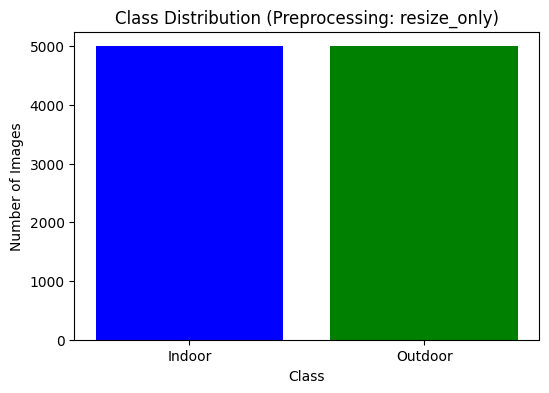

Original Image Dimensions (sample of 10, resize_only): Mean Width=256.0, Mean Height=256.0
Original Image Dimensions Std: Width=0.0, Height=0.0
Mean RGB Values (resize_only): R=108.5, G=115.9, B=121.3
Std of RGB Values (resize_only): R=35.9, G=30.0, B=29.8


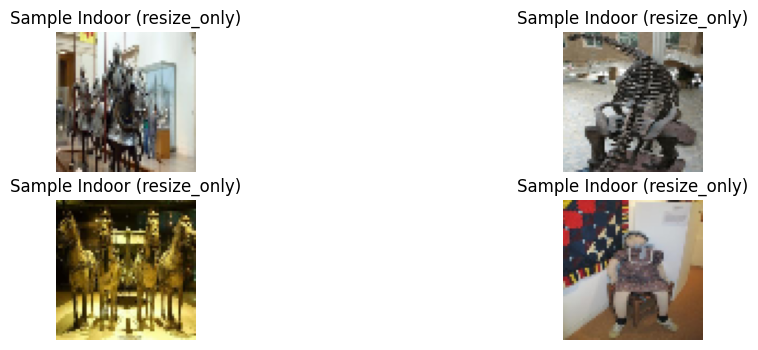


Exploring preprocessing method: normalize
Loaded 10000 training images for normalize.


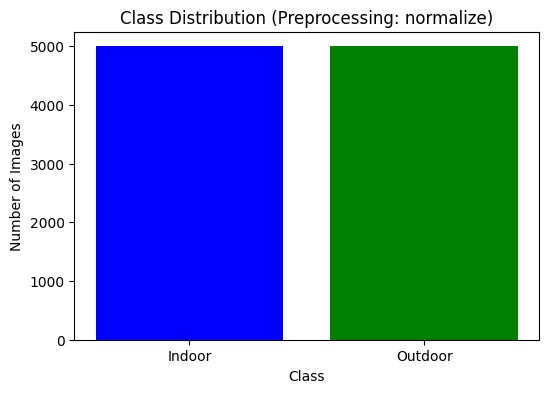

Original Image Dimensions (sample of 10, normalize): Mean Width=256.0, Mean Height=256.0
Original Image Dimensions Std: Width=0.0, Height=0.0
Mean RGB Values (normalize): R=0.4, G=0.5, B=0.5
Std of RGB Values (normalize): R=0.1, G=0.1, B=0.1


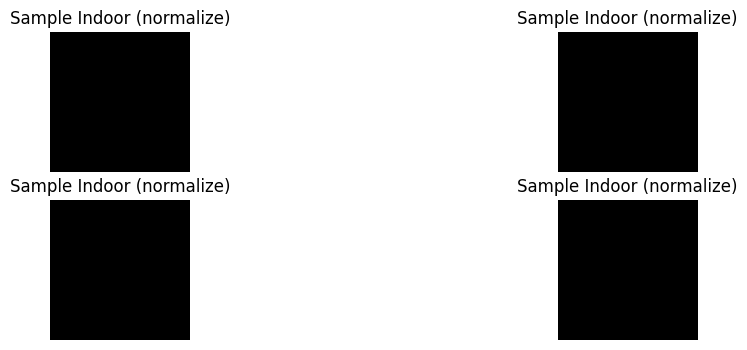


Exploring preprocessing method: grayscale
Loaded 10000 training images for grayscale.


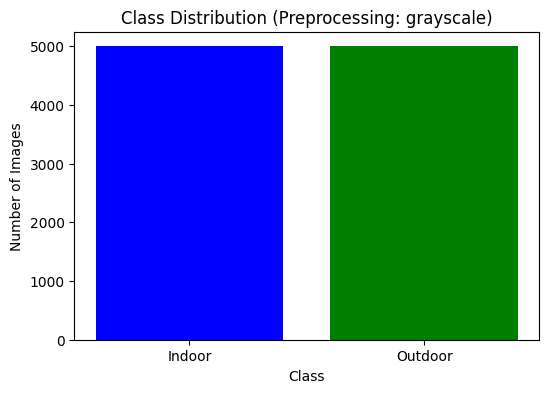

Original Image Dimensions (sample of 10, grayscale): Mean Width=256.0, Mean Height=256.0
Original Image Dimensions Std: Width=0.0, Height=0.0
Mean RGB Values (grayscale): R=116.7, G=116.7, B=116.7
Std of RGB Values (grayscale): R=29.1, G=29.1, B=29.1


<ipython-input-23-9f14732be408>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Mean RGB Values ({method}): R={float(rgb_mean[0]):.1f}, G={float(rgb_mean[1]):.1f}, B={float(rgb_mean[2]):.1f}")
<ipython-input-23-9f14732be408>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Std of RGB Values ({method}): R={float(rgb_std[0]):.1f}, G={float(rgb_std[1]):.1f}, B={float(rgb_std[2]):.1f}")


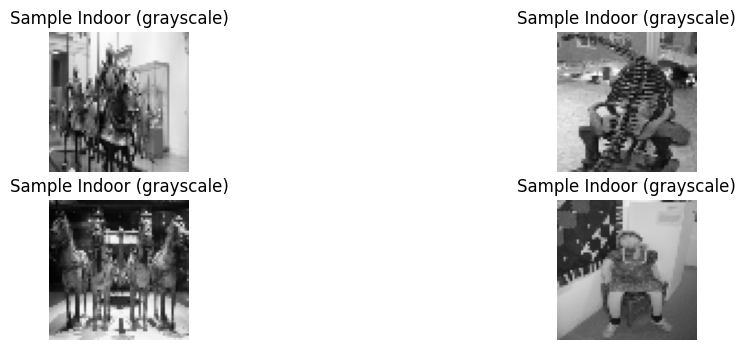


Exploring preprocessing method: histogram_equalization
Loaded 10000 training images for histogram_equalization.


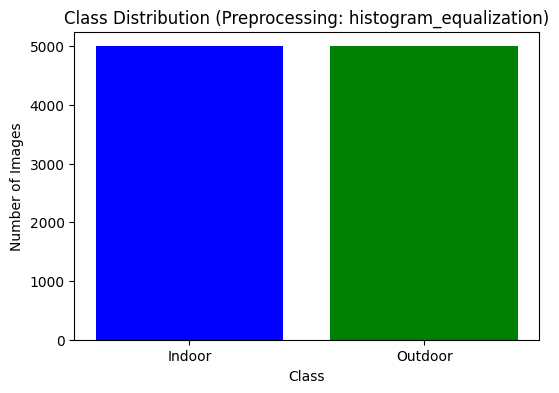

Original Image Dimensions (sample of 10, histogram_equalization): Mean Width=256.0, Mean Height=256.0
Original Image Dimensions Std: Width=0.0, Height=0.0
Mean RGB Values (histogram_equalization): R=120.2, G=127.7, B=132.8
Std of RGB Values (histogram_equalization): R=18.0, G=5.0, B=12.5


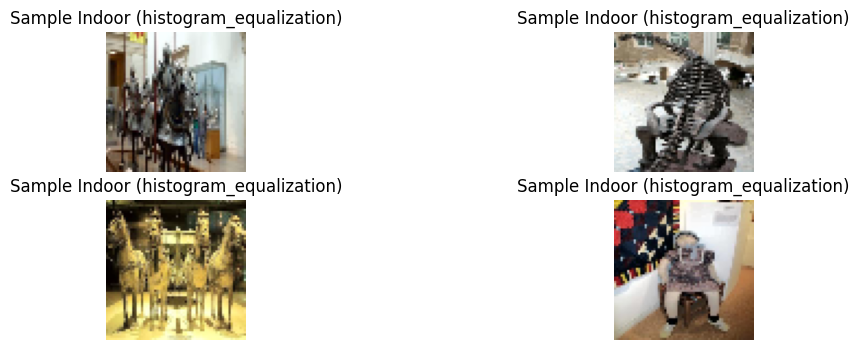


Proceeding with resize_only for modeling and hyperparameter tuning...
Loaded 10000 training images for modeling.

Random Forest (Default) Validation Accuracy: 0.7733

Random Forest (Tuned 1) Validation Accuracy: 0.7793

Random Forest (Tuned 2) Validation Accuracy: 0.7820
Debug - y_val shape: (1500,), y_pred_rf shape: (1500,), y_prob_rf shape: (1500,)

Random Forest Performance:
Accuracy: 0.7820
Precision: 0.7779
Recall: 0.7893
F1-Score: 0.7836
ROC-AUC: 0.8553
Cohen's Kappa: 0.5640
Matthews CC: 0.5641
Confusion Matrix:
[[581 169]
 [158 592]]

Decision Tree (Default) Validation Accuracy: 0.7713

Decision Tree (Tuned 1) Validation Accuracy: 0.7653

Decision Tree (Tuned 2) Validation Accuracy: 0.7747

Decision Tree (Supervised) Performance:
Accuracy: 0.7747
Precision: 0.7910
Recall: 0.7467
F1-Score: 0.7682
ROC-AUC: 0.8216
Cohen's Kappa: 0.5493
Matthews CC: 0.5502
Confusion Matrix:
[[602 148]
 [190 560]]

Gradient Boosting (Default) Validation Accuracy: 0.7813

Gradient Boosting (Tuned 1) 

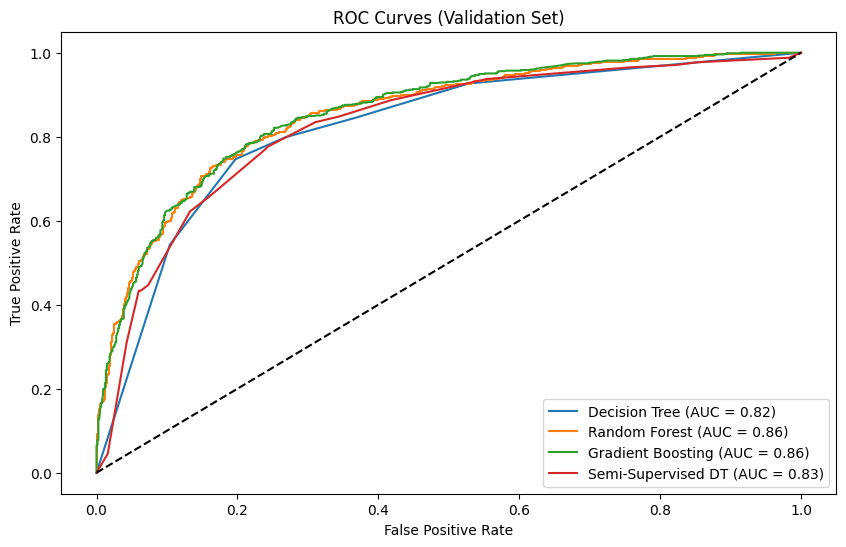

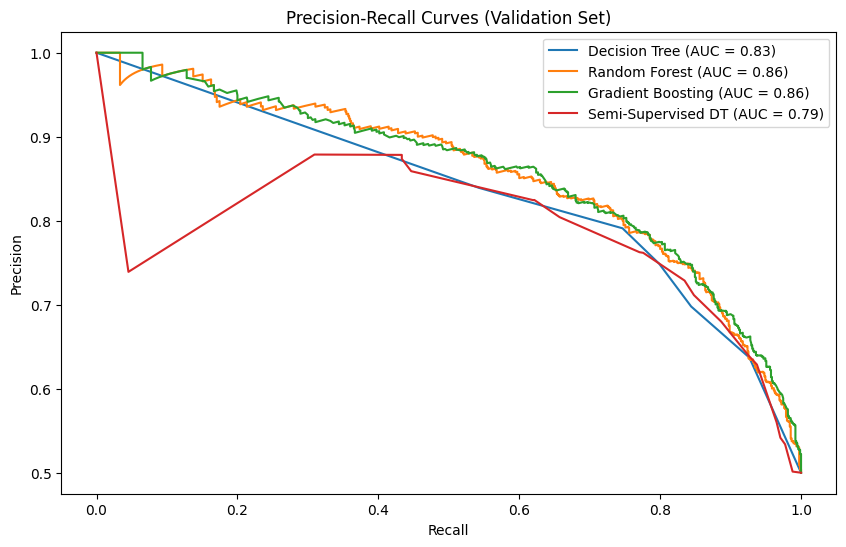

Plotting confusion matrix for Random Forest


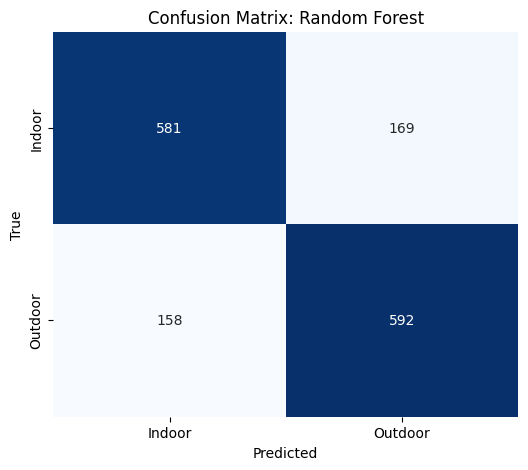

Plotting confusion matrix for Decision Tree


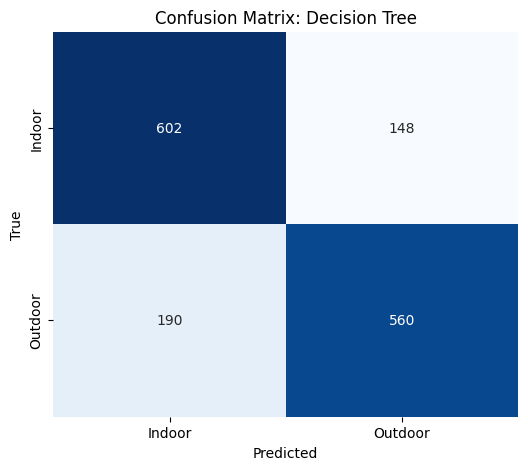

Plotting confusion matrix for Gradient Boosting


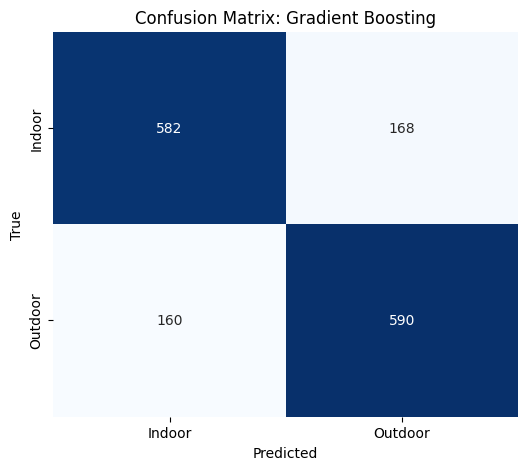

Plotting confusion matrix for Semi-Supervised DT


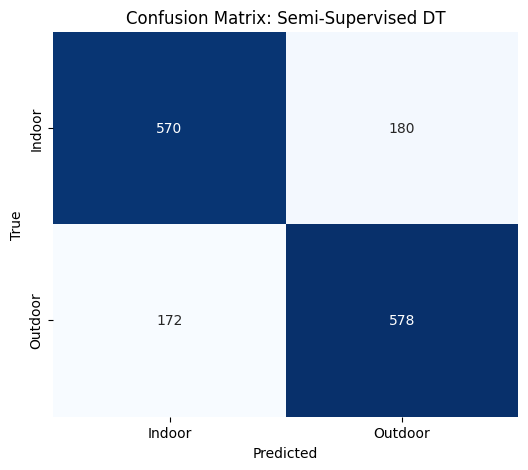

Plotting feature importance for Random Forest


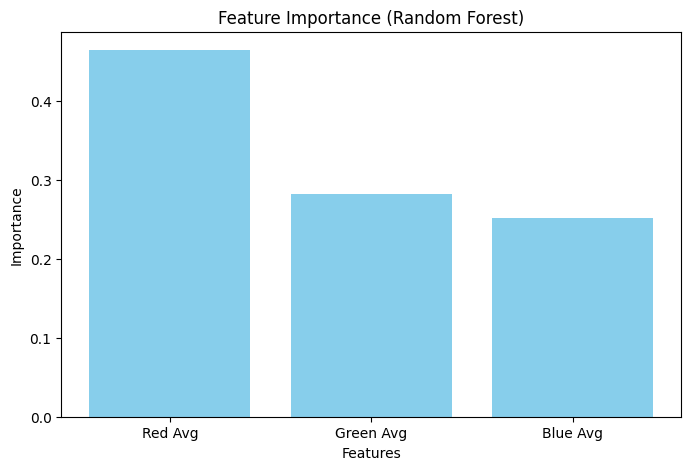

Plotting learning curve for Random Forest


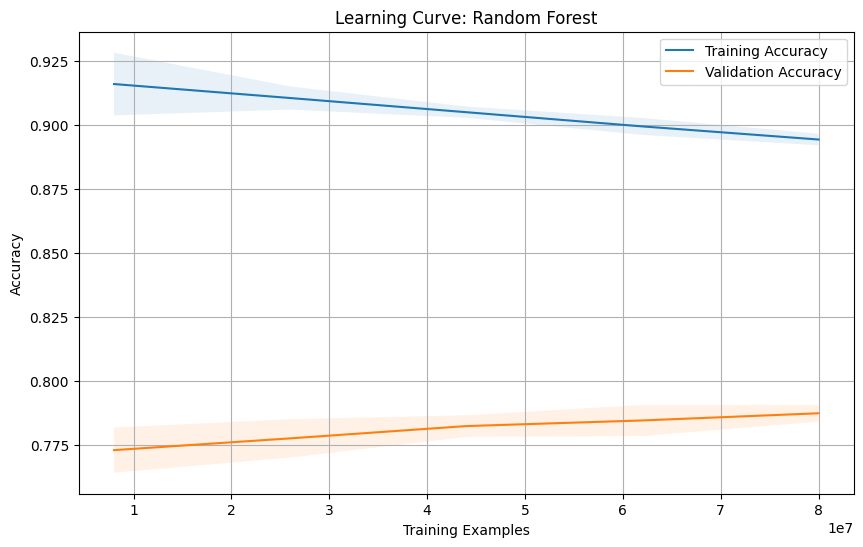

In [ ]:
if __name__ == "__main__":
    phase_1()

#Phase 2


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import zipfile
from tqdm import tqdm
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, roc_auc_score,
                            cohen_kappa_score, matthews_corrcoef,
                            roc_curve, precision_recall_curve, auc)
from sklearn.model_selection import train_test_split
import joblib

In [2]:
# Define constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


Using device: cuda


In [3]:
class MuseumDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Function to extract ZIP files
def extract_zip(zip_file, extract_path):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Extracted {zip_file} to {extract_path}")

# Function to load image data with preprocessing for CNN
def load_data_for_cnn(indoor_path, outdoor_path, img_size=IMG_SIZE):
    X, y = [], []

    # Load indoor images
    print(f"Loading indoor images from {indoor_path}")
    for img_name in tqdm(os.listdir(indoor_path)):
        if img_name.endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(indoor_path, img_name)
            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                X.append(img)
                y.append(0)  # Indoor class
            except Exception as e:
                print(f"Error loading {img_path}: {str(e)}")

    # Load outdoor images
    print(f"Loading outdoor images from {outdoor_path}")
    for img_name in tqdm(os.listdir(outdoor_path)):
        if img_name.endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(outdoor_path, img_name)
            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, img_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                X.append(img)
                y.append(1)  # Outdoor class
            except Exception as e:
                print(f"Error loading {img_path}: {str(e)}")

    return np.array(X), np.array(y)

# Define CNN architectures
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 64x64
        x = self.pool(F.relu(self.conv2(x)))  # 32x32
        x = self.pool(F.relu(self.conv3(x)))  # 16x16
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [4]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.batch_norm4 = nn.BatchNorm2d(256)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))  # 64x64
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))  # 32x32
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x))))  # 16x16
        x = self.pool(F.relu(self.batch_norm4(self.conv4(x))))  # 8x8
        x = x.view(-1, 256 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

class LightCNN(nn.Module):
    def __init__(self):
        super(LightCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 32 * 32, 64)
        self.fc2 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 64x64
        x = self.pool(F.relu(self.conv2(x)))  # 32x32
        x = x.view(-1, 32 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [5]:
# Function to train CNN model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS):
    model.to(DEVICE)
    best_val_acc = 0.0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / total
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)"):
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / val_total
        val_epoch_acc = val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

        # Save best model
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), f"{model.__class__.__name__}_best.pth")
            print(f"Model saved with validation accuracy: {best_val_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs


In [6]:
# Function to evaluate CNN model
def evaluate_cnn_model(model, test_loader):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = F.softmax(outputs, dim=1)[:, 1]  # Class 1 probability (outdoor)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# Function to load model for inference
def load_model_for_inference(model_class, model_path):
    model = model_class()
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    return model

# Function for single image prediction
def predict_single_image(model, image_path, transform):
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMG_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply transforms
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)

    # Make prediction
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

    # Get prediction and probability
    pred_class = 'Indoor' if predicted.item() == 0 else 'Outdoor'
    confidence = probs[0][predicted.item()].item()

    return pred_class, confidence, img

# Function to plot training/validation curves
def plot_training_curves(train_losses, val_losses, train_accs, val_accs, model_name):
    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss Curves')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy Curves')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{model_name}_learning_curves.png")
    plt.show()

# Function to visualize CNN predictions
def visualize_predictions(model, test_loader, num_images=8):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 8))

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if images_so_far >= num_images:
                    return

                images_so_far += 1
                ax = plt.subplot(2, num_images//2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Pred: {["Indoor", "Outdoor"][preds[j]]}\nTrue: {["Indoor", "Outdoor"][labels[j]]}',
                             color=('green' if preds[j] == labels[j] else 'red'))

                # Convert tensor to numpy array
                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))

                # Denormalize
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)

                plt.imshow(inp)

    plt.tight_layout()
    plt.savefig(f"{model.__class__.__name__}_predictions.png")
    plt.show()

In [7]:
# Extended evaluation function with additional metrics
def evaluate_model(y_true, y_pred, y_prob, model_name):
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_prob),
        "Cohen's Kappa": cohen_kappa_score(y_true, y_pred),
        "Matthews CC": matthews_corrcoef(y_true, y_pred)
    }

    print(f"\n{model_name} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    print(f"Confusion Matrix:\n{cm}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Indoor", "Outdoor"], yticklabels=["Indoor", "Outdoor"])
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"cm_{model_name.lower().replace(' ', '_')}.png")
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve: {model_name}")
    plt.legend(loc="lower right")
    plt.savefig(f"roc_{model_name.lower().replace(' ', '_')}.png")
    plt.show()

    return metrics, cm

# Function to compare models
def compare_models(metrics_dict):
    # Create a DataFrame for comparison
    model_names = list(metrics_dict.keys())
    metrics = list(metrics_dict[model_names[0]].keys())

    comparison_data = []
    for model_name in model_names:
        model_metrics = metrics_dict[model_name]
        comparison_data.append(list(model_metrics.values()))

    comparison_df = pd.DataFrame(comparison_data, index=model_names, columns=metrics)
    print("\nModel Comparison:")
    print(comparison_df)

    # Plot comparison chart
    plt.figure(figsize=(12, 8))
    comparison_df.plot(kind='bar', figsize=(12, 8))
    plt.title("Model Performance Comparison")
    plt.xlabel("Models")
    plt.ylabel("Score")
    plt.legend(title="Metrics")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig("model_comparison.png")
    plt.show()

    return comparison_df

In [10]:
def main():
    # Define paths to pre-uploaded ZIP files in Colab
    training_zip = "/content/Museum_Training.zip"
    test_zip = "/content/Museum_Test.zip"

    # Check if ZIP files exist
    if not os.path.exists(training_zip) or not os.path.exists(test_zip):
        print("Error: ZIP files not found in /content/. Please ensure Museum_Training.zip and Museum_Test.zip are uploaded.")
        return

    # Extract ZIP files
    extract_path = "/content"
    extract_zip(training_zip, extract_path)
    extract_zip(test_zip, extract_path)

    # Define paths based on the structure
    train_indoor_path = os.path.join(extract_path, "Training", "museum-indoor")
    train_outdoor_path = os.path.join(extract_path, "Training", "museum-outdoor")
    test_indoor_path = os.path.join(extract_path, "Museum_Validation", "museum-indoor")
    test_outdoor_path = os.path.join(extract_path, "Museum_Validation", "museum-outdoor")

    # Verify paths exist
    for path in [train_indoor_path, train_outdoor_path, test_indoor_path, test_outdoor_path]:
        if not os.path.exists(path):
            print(f"Error: {path} does not exist. Check ZIP structure.")
            return

    # Data transforms
    data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load the data
    print("Loading training data...")
    X_train_full, y_train_full = load_data_for_cnn(train_indoor_path, train_outdoor_path)
    print(f"Loaded {len(X_train_full)} training images")

    print("Loading test data...")
    X_test, y_test = load_data_for_cnn(test_indoor_path, test_outdoor_path)
    print(f"Loaded {len(X_test)} test images")

    # Split training data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.15, random_state=42, stratify=y_train_full
    )
    print(f"Train set: {len(X_train)} images, Validation set: {len(X_val)} images")

    # Create datasets and data loaders
    train_dataset = MuseumDataset(X_train, y_train, transform=data_transforms)
    val_dataset = MuseumDataset(X_val, y_val, transform=data_transforms)
    test_dataset = MuseumDataset(X_test, y_test, transform=data_transforms)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # Create dictionaries to store results
    all_metrics = {}
    all_cms = {}

    # Define models and configurations for hyperparameter tuning
    cnn_configs = [
        {"model_class": SimpleCNN, "name": "Simple CNN"},
        {"model_class": DeepCNN, "name": "Deep CNN"},
        {"model_class": LightCNN, "name": "Light CNN"}
    ]

    # Train and evaluate each model configuration
    for config in cnn_configs:
        model_class = config["model_class"]
        model_name = config["name"]

        print(f"\n{'-'*40}")
        print(f"Training {model_name}")
        print(f"{'-'*40}")

        model = model_class()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train the model
        train_losses, val_losses, train_accs, val_accs = train_model(
            model, train_loader, val_loader, criterion, optimizer
        )

        # Plot training curves
        plot_training_curves(train_losses, val_losses, train_accs, val_accs, model_name)

        # Load the best model
        best_model = model_class()
        best_model.load_state_dict(torch.load(f"{model_class.__name__}_best.pth", map_location=DEVICE))
        best_model.to(DEVICE)

        # Evaluate on test set
        y_true, y_pred, y_prob = evaluate_cnn_model(best_model, test_loader)
        metrics, cm = evaluate_model(y_true, y_pred, y_prob, model_name)

        all_metrics[model_name] = metrics
        all_cms[model_name] = cm

        # Visualize some predictions
        visualize_predictions(best_model, test_loader)

    # Compare models
    comparison_df = compare_models(all_metrics)

    # Hyperparameter study - Learning Rate
    print("\n" + "-"*40)
    print("Hyperparameter Study: Learning Rate")
    print("-"*40)

    lr_values = [0.0001, 0.001, 0.01]
    lr_metrics = {}

    for lr in lr_values:
        model = SimpleCNN()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        print(f"\nTraining with learning rate: {lr}")
        train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

        # Load the best model
        best_model = SimpleCNN()
        best_model.load_state_dict(torch.load(f"SimpleCNN_best.pth", map_location=DEVICE))
        best_model.to(DEVICE)

        # Evaluate
        y_true, y_pred, y_prob = evaluate_cnn_model(best_model, test_loader)
        metrics, _ = evaluate_model(y_true, y_pred, y_prob, f"CNN (LR={lr})")

        lr_metrics[f"LR={lr}"] = metrics

    # Plot learning rate comparison
    lr_df = pd.DataFrame({k: v["Accuracy"] for k, v in lr_metrics.items()}, index=["Accuracy"]).T
    plt.figure(figsize=(8, 6))
    lr_df.plot(kind="bar", figsize=(8, 5))
    plt.title("CNN Performance by Learning Rate")
    plt.xlabel("Learning Rate")
    plt.ylabel("Accuracy")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig("lr_comparison.png")
    plt.show()

    # Hyperparameter study - Network Depth
    print("\n" + "-"*40)
    print("Hyperparameter Study: Network Architecture")
    print("-"*40)

    # Load the best models
    simple_cnn = SimpleCNN()
    simple_cnn.load_state_dict(torch.load("SimpleCNN_best.pth", map_location=DEVICE))
    simple_cnn.to(DEVICE)

    deep_cnn = DeepCNN()
    deep_cnn.load_state_dict(torch.load("DeepCNN_best.pth", map_location=DEVICE))
    deep_cnn.to(DEVICE)

    light_cnn = LightCNN()
    light_cnn.load_state_dict(torch.load("LightCNN_best.pth", map_location=DEVICE))
    light_cnn.to(DEVICE)

    # Compare with decision tree models from phase 1
    try:
        # Load models from phase 1
        dt_model = joblib.load("dt_model.pkl")
        rf_model = joblib.load("rf_model.pkl")
        gb_model = joblib.load("gb_model.pkl")
        dt_semi_model = joblib.load("dt_semi_model.pkl")

        # Extract features for decision tree models
        X_test_tree = np.array([np.mean(img, axis=(0, 1)) for img in X_test])

        # Make predictions
        dt_pred = dt_model.predict(X_test_tree)
        dt_prob = dt_model.predict_proba(X_test_tree)[:, 1]

        rf_pred = rf_model.predict(X_test_tree)
        rf_prob = rf_model.predict_proba(X_test_tree)[:, 1]

        gb_pred = gb_model.predict(X_test_tree)
        gb_prob = gb_model.predict_proba(X_test_tree)[:, 1]

        # Add to metrics dictionary
        dt_metrics, _ = evaluate_model(y_test, dt_pred, dt_prob, "Decision Tree")
        all_metrics["Decision Tree"] = dt_metrics

        rf_metrics, _ = evaluate_model(y_test, rf_pred, rf_prob, "Random Forest")
        all_metrics["Random Forest"] = rf_metrics

        gb_metrics, _ = evaluate_model(y_test, gb_pred, gb_prob, "Gradient Boosting")
        all_metrics["Gradient Boosting"] = gb_metrics

        # Final comparison of all models
        final_df = compare_models(all_metrics)

        # Save final comparison to CSV
        final_df.to_csv("model_comparison_results.csv")

    except Exception as e:
        print(f"Error loading phase 1 models: {str(e)}")
        print("Skipping comparison with phase 1 models.")

    print("\nSaving final models...")
    # Save the best CNN model for demo
    torch.save(deep_cnn.state_dict(), "best_cnn_model.pth")

    # Create a demo function
    def demo_prediction(model, image_path):
        pred_class, confidence, img = predict_single_image(model, image_path, data_transforms)

        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"Prediction: {pred_class} (Confidence: {confidence:.2f})")
        plt.axis('off')
        plt.show()

        return pred_class, confidence
    print("\nCNN training and evaluation complete!")

Extracted /content/Museum_Training.zip to /content
Extracted /content/Museum_Test.zip to /content
Loading training data...
Loading indoor images from /content/Training/museum-indoor


100%|██████████| 5000/5000 [00:02<00:00, 1714.59it/s]


Loading outdoor images from /content/Training/museum-outdoor


100%|██████████| 5000/5000 [00:02<00:00, 2048.07it/s]


Loaded 10000 training images
Loading test data...
Loading indoor images from /content/Museum_Validation/museum-indoor


100%|██████████| 100/100 [00:00<00:00, 2218.20it/s]


Loading outdoor images from /content/Museum_Validation/museum-outdoor


100%|██████████| 100/100 [00:00<00:00, 2161.67it/s]

Loaded 200 test images


Train set: 8500 images, Validation set: 1500 images

----------------------------------------
Training Simple CNN
----------------------------------------


Epoch 1/20 (Val): 100%|██████████| 47/47 [00:01<00:00, 36.93it/s]


Epoch 1/20: Train Loss: 0.3220, Train Acc: 0.8767, Val Loss: 0.2609, Val Acc: 0.8913
Model saved with validation accuracy: 0.8913


Epoch 2/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 60.90it/s]


Epoch 2/20: Train Loss: 0.2422, Train Acc: 0.9116, Val Loss: 0.2506, Val Acc: 0.9073
Model saved with validation accuracy: 0.9073


Epoch 3/20 (Val): 100%|██████████| 47/47 [00:01<00:00, 41.86it/s]


Epoch 3/20: Train Loss: 0.2128, Train Acc: 0.9238, Val Loss: 0.2315, Val Acc: 0.9173
Model saved with validation accuracy: 0.9173


Epoch 4/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 57.71it/s]


Epoch 4/20: Train Loss: 0.1821, Train Acc: 0.9315, Val Loss: 0.2414, Val Acc: 0.9133


Epoch 5/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 52.74it/s]


Epoch 5/20: Train Loss: 0.1563, Train Acc: 0.9389, Val Loss: 0.2625, Val Acc: 0.9027


Epoch 6/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 57.64it/s]


Epoch 6/20: Train Loss: 0.1196, Train Acc: 0.9560, Val Loss: 0.2692, Val Acc: 0.9073


Epoch 7/20 (Val): 100%|██████████| 47/47 [00:02<00:00, 23.11it/s]


Epoch 7/20: Train Loss: 0.0819, Train Acc: 0.9727, Val Loss: 0.2913, Val Acc: 0.9153


Epoch 8/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 58.27it/s]


Epoch 8/20: Train Loss: 0.0732, Train Acc: 0.9740, Val Loss: 0.3377, Val Acc: 0.9073


Epoch 9/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 50.25it/s]


Epoch 9/20: Train Loss: 0.0477, Train Acc: 0.9831, Val Loss: 0.3446, Val Acc: 0.9113


Epoch 10/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 58.17it/s]


Epoch 10/20: Train Loss: 0.0317, Train Acc: 0.9894, Val Loss: 0.4487, Val Acc: 0.9033


Epoch 11/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 58.03it/s]


Epoch 11/20: Train Loss: 0.0292, Train Acc: 0.9899, Val Loss: 0.4120, Val Acc: 0.9127


Epoch 12/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 57.38it/s]


Epoch 12/20: Train Loss: 0.0248, Train Acc: 0.9921, Val Loss: 0.5275, Val Acc: 0.9027


Epoch 13/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 59.14it/s]


Epoch 13/20: Train Loss: 0.0270, Train Acc: 0.9912, Val Loss: 0.4951, Val Acc: 0.9107


Epoch 14/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 58.68it/s]


Epoch 14/20: Train Loss: 0.0210, Train Acc: 0.9933, Val Loss: 0.5474, Val Acc: 0.9080


Epoch 15/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 55.67it/s]


Epoch 15/20: Train Loss: 0.0359, Train Acc: 0.9868, Val Loss: 0.5122, Val Acc: 0.9113


Epoch 16/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 52.30it/s]


Epoch 16/20: Train Loss: 0.0110, Train Acc: 0.9965, Val Loss: 0.4955, Val Acc: 0.9120


Epoch 17/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 58.02it/s]


Epoch 17/20: Train Loss: 0.0184, Train Acc: 0.9934, Val Loss: 0.5224, Val Acc: 0.9027


Epoch 18/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 58.03it/s]


Epoch 18/20: Train Loss: 0.0243, Train Acc: 0.9924, Val Loss: 0.5182, Val Acc: 0.9113


Epoch 19/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 58.70it/s]


Epoch 19/20: Train Loss: 0.0136, Train Acc: 0.9961, Val Loss: 0.5286, Val Acc: 0.9147


Epoch 20/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 57.77it/s]


Epoch 20/20: Train Loss: 0.0213, Train Acc: 0.9928, Val Loss: 0.5528, Val Acc: 0.9080


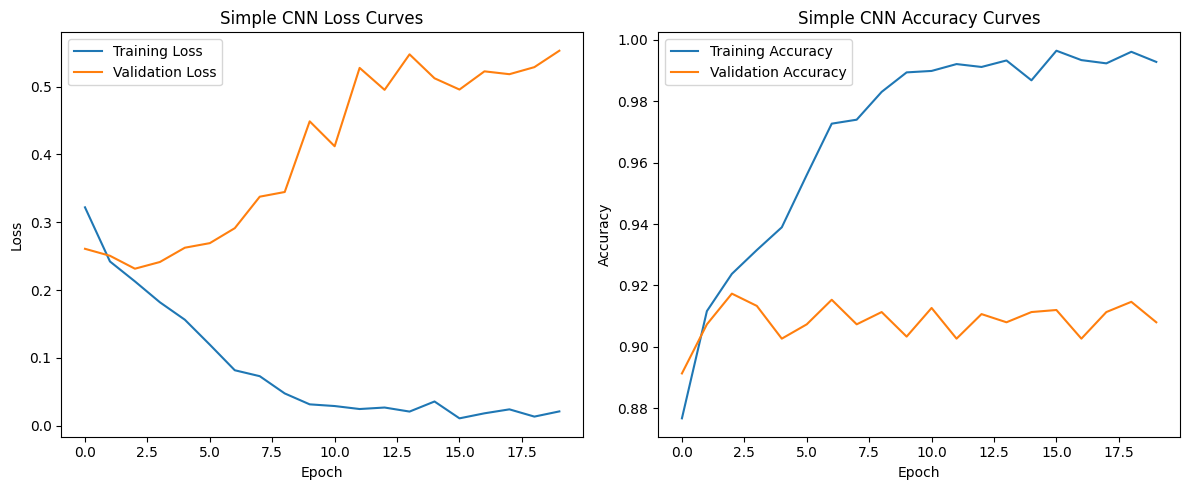

Evaluating: 100%|██████████| 7/7 [00:00<00:00, 29.61it/s]



Simple CNN Performance:
Accuracy: 0.9150
Precision: 0.9663
Recall: 0.8600
F1-Score: 0.9101
ROC-AUC: 0.9708
Cohen's Kappa: 0.8300
Matthews CC: 0.8351
Confusion Matrix:
[[97  3]
 [14 86]]


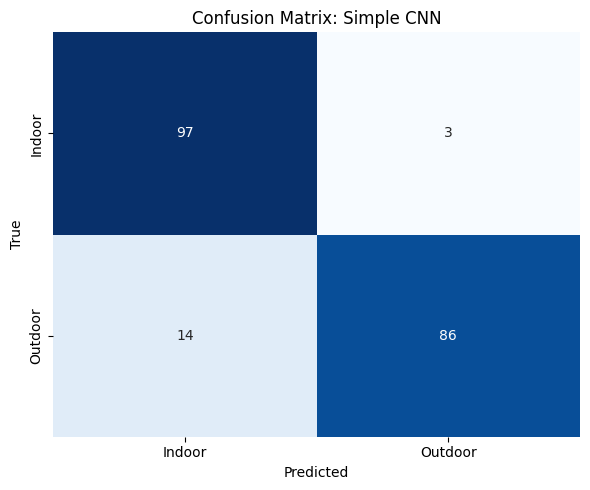

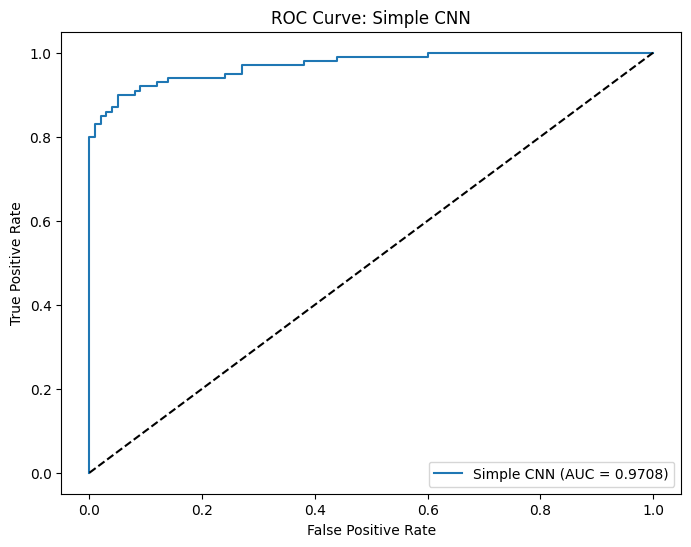


----------------------------------------
Training Deep CNN
----------------------------------------


Epoch 1/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 51.26it/s]


Epoch 1/20: Train Loss: 0.4700, Train Acc: 0.8331, Val Loss: 0.2873, Val Acc: 0.8873
Model saved with validation accuracy: 0.8873


Epoch 2/20 (Val): 100%|██████████| 47/47 [00:01<00:00, 38.61it/s]


Epoch 2/20: Train Loss: 0.3004, Train Acc: 0.8894, Val Loss: 0.2448, Val Acc: 0.9047
Model saved with validation accuracy: 0.9047


Epoch 3/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 51.75it/s]


Epoch 3/20: Train Loss: 0.2733, Train Acc: 0.9053, Val Loss: 0.2320, Val Acc: 0.9140
Model saved with validation accuracy: 0.9140


Epoch 4/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 52.12it/s]


Epoch 4/20: Train Loss: 0.2558, Train Acc: 0.9096, Val Loss: 0.2553, Val Acc: 0.8927


Epoch 5/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 52.22it/s]


Epoch 5/20: Train Loss: 0.2254, Train Acc: 0.9186, Val Loss: 0.2287, Val Acc: 0.9167
Model saved with validation accuracy: 0.9167


Epoch 6/20 (Val): 100%|██████████| 47/47 [00:01<00:00, 36.20it/s]


Epoch 6/20: Train Loss: 0.2125, Train Acc: 0.9259, Val Loss: 0.3297, Val Acc: 0.8853


Epoch 7/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 51.72it/s]


Epoch 7/20: Train Loss: 0.2072, Train Acc: 0.9244, Val Loss: 0.2012, Val Acc: 0.9233
Model saved with validation accuracy: 0.9233


Epoch 8/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 52.14it/s]


Epoch 8/20: Train Loss: 0.1920, Train Acc: 0.9349, Val Loss: 0.2051, Val Acc: 0.9193


Epoch 9/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 51.18it/s]


Epoch 9/20: Train Loss: 0.1845, Train Acc: 0.9349, Val Loss: 0.2562, Val Acc: 0.9160


Epoch 10/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 50.72it/s]


Epoch 10/20: Train Loss: 0.1687, Train Acc: 0.9400, Val Loss: 0.2190, Val Acc: 0.9240
Model saved with validation accuracy: 0.9240


Epoch 11/20 (Val): 100%|██████████| 47/47 [00:01<00:00, 32.62it/s]


Epoch 11/20: Train Loss: 0.1571, Train Acc: 0.9444, Val Loss: 0.2210, Val Acc: 0.9227


Epoch 12/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 51.93it/s]


Epoch 12/20: Train Loss: 0.1484, Train Acc: 0.9479, Val Loss: 0.2090, Val Acc: 0.9327
Model saved with validation accuracy: 0.9327


Epoch 13/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 51.21it/s]


Epoch 13/20: Train Loss: 0.1508, Train Acc: 0.9488, Val Loss: 0.1849, Val Acc: 0.9327


Epoch 14/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 51.63it/s]


Epoch 14/20: Train Loss: 0.1340, Train Acc: 0.9533, Val Loss: 0.2024, Val Acc: 0.9287


Epoch 15/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 47.09it/s]


Epoch 15/20: Train Loss: 0.1225, Train Acc: 0.9574, Val Loss: 0.2292, Val Acc: 0.9247


Epoch 16/20 (Val): 100%|██████████| 47/47 [00:01<00:00, 45.40it/s]


Epoch 16/20: Train Loss: 0.1121, Train Acc: 0.9593, Val Loss: 0.2307, Val Acc: 0.9247


Epoch 17/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 52.29it/s]


Epoch 17/20: Train Loss: 0.1003, Train Acc: 0.9621, Val Loss: 0.2383, Val Acc: 0.9313


Epoch 18/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 51.09it/s]


Epoch 18/20: Train Loss: 0.0926, Train Acc: 0.9678, Val Loss: 0.2433, Val Acc: 0.9307


Epoch 19/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 52.22it/s]


Epoch 19/20: Train Loss: 0.0872, Train Acc: 0.9694, Val Loss: 0.2577, Val Acc: 0.9313


Epoch 20/20 (Val): 100%|██████████| 47/47 [00:01<00:00, 33.34it/s]


Epoch 20/20: Train Loss: 0.0859, Train Acc: 0.9705, Val Loss: 0.3537, Val Acc: 0.9253


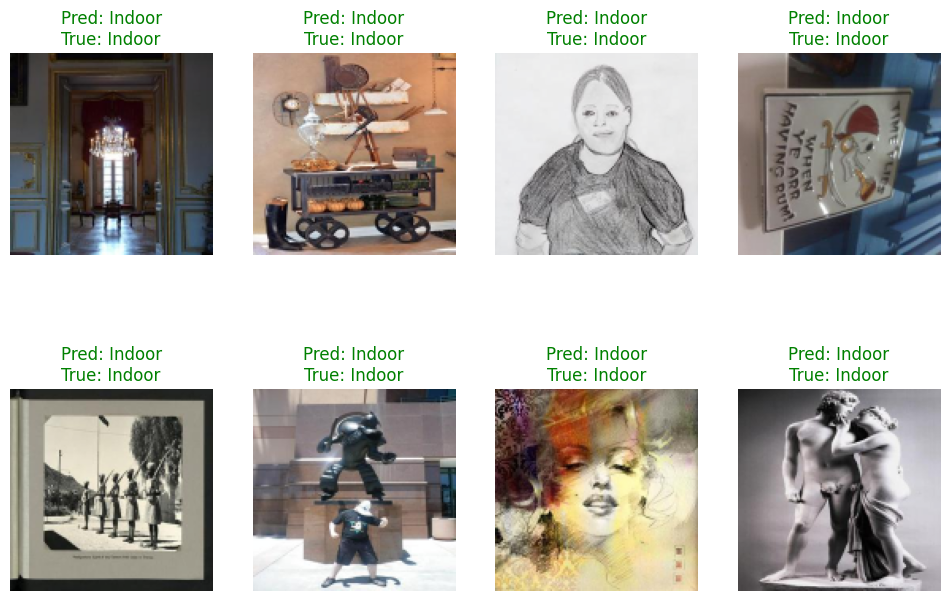

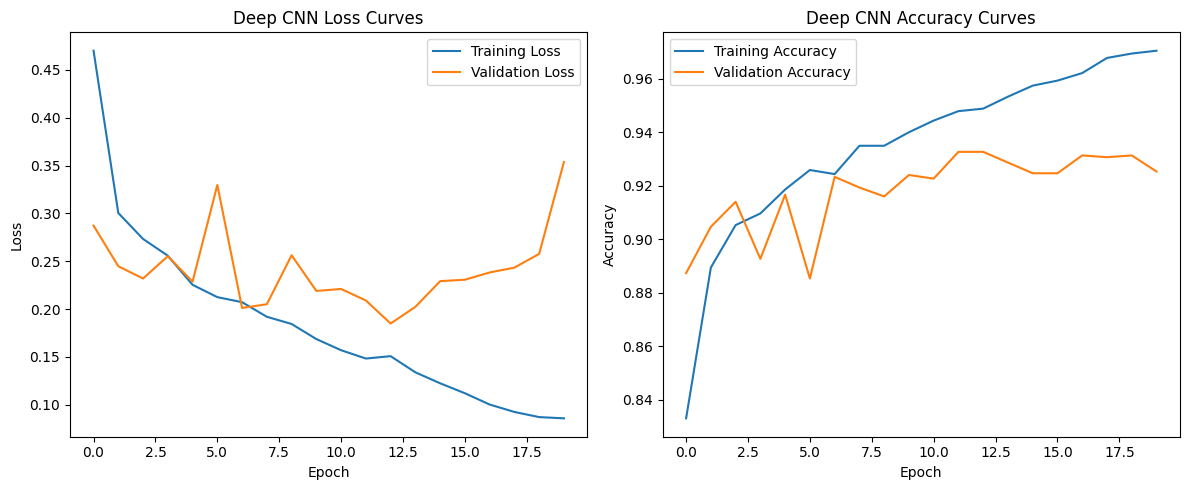

Evaluating: 100%|██████████| 7/7 [00:00<00:00, 24.10it/s]



Deep CNN Performance:
Accuracy: 0.9300
Precision: 0.9674
Recall: 0.8900
F1-Score: 0.9271
ROC-AUC: 0.9775
Cohen's Kappa: 0.8600
Matthews CC: 0.8628
Confusion Matrix:
[[97  3]
 [11 89]]


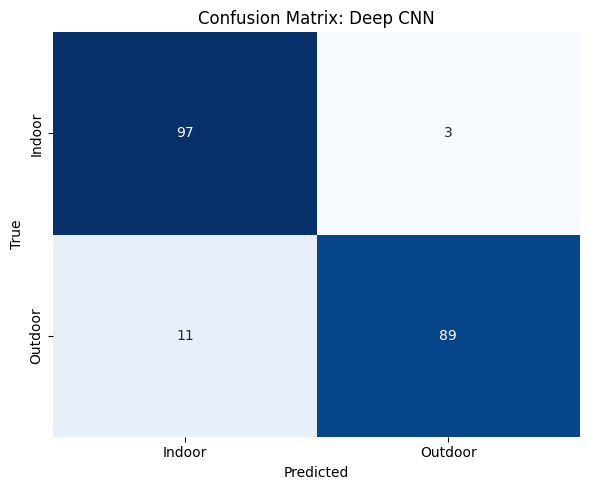

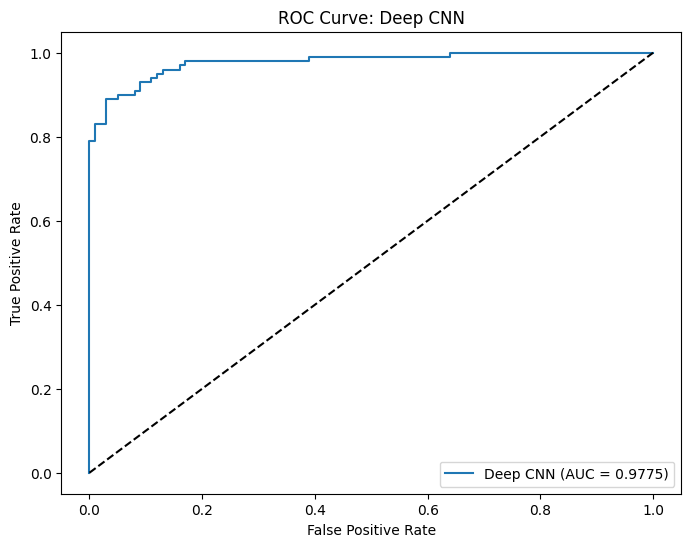


----------------------------------------
Training Light CNN
----------------------------------------


Epoch 1/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 54.44it/s]


Epoch 1/20: Train Loss: 0.3573, Train Acc: 0.8682, Val Loss: 0.2905, Val Acc: 0.8840
Model saved with validation accuracy: 0.8840


Epoch 2/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 52.62it/s]


Epoch 2/20: Train Loss: 0.2389, Train Acc: 0.9131, Val Loss: 0.2364, Val Acc: 0.9067
Model saved with validation accuracy: 0.9067


Epoch 3/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 52.04it/s]


Epoch 3/20: Train Loss: 0.1982, Train Acc: 0.9279, Val Loss: 0.2988, Val Acc: 0.8827


Epoch 4/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 49.94it/s]


Epoch 4/20: Train Loss: 0.1619, Train Acc: 0.9391, Val Loss: 0.2558, Val Acc: 0.9053


Epoch 5/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 49.87it/s]


Epoch 5/20: Train Loss: 0.1204, Train Acc: 0.9547, Val Loss: 0.2669, Val Acc: 0.9100
Model saved with validation accuracy: 0.9100


Epoch 6/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 51.80it/s]


Epoch 6/20: Train Loss: 0.0900, Train Acc: 0.9666, Val Loss: 0.3304, Val Acc: 0.9033


Epoch 7/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 50.26it/s]


Epoch 7/20: Train Loss: 0.0622, Train Acc: 0.9773, Val Loss: 0.4455, Val Acc: 0.9060


Epoch 8/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 53.43it/s]


Epoch 8/20: Train Loss: 0.0487, Train Acc: 0.9825, Val Loss: 0.4229, Val Acc: 0.9020


Epoch 9/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 55.96it/s]


Epoch 9/20: Train Loss: 0.0330, Train Acc: 0.9886, Val Loss: 0.5116, Val Acc: 0.9027


Epoch 10/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 54.10it/s]


Epoch 10/20: Train Loss: 0.0364, Train Acc: 0.9872, Val Loss: 0.5289, Val Acc: 0.9087


Epoch 11/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 50.17it/s]


Epoch 11/20: Train Loss: 0.0269, Train Acc: 0.9901, Val Loss: 0.5749, Val Acc: 0.8993


Epoch 12/20 (Val): 100%|██████████| 47/47 [00:01<00:00, 42.77it/s]


Epoch 12/20: Train Loss: 0.0182, Train Acc: 0.9936, Val Loss: 0.5837, Val Acc: 0.9053


Epoch 13/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 53.59it/s]


Epoch 13/20: Train Loss: 0.0142, Train Acc: 0.9941, Val Loss: 0.6201, Val Acc: 0.8953


Epoch 14/20 (Val): 100%|██████████| 47/47 [00:01<00:00, 35.15it/s]


Epoch 14/20: Train Loss: 0.0166, Train Acc: 0.9946, Val Loss: 0.6249, Val Acc: 0.8913


Epoch 15/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 54.15it/s]


Epoch 15/20: Train Loss: 0.0185, Train Acc: 0.9939, Val Loss: 0.5715, Val Acc: 0.8987


Epoch 16/20 (Val): 100%|██████████| 47/47 [00:01<00:00, 33.85it/s]


Epoch 16/20: Train Loss: 0.0296, Train Acc: 0.9918, Val Loss: 0.5069, Val Acc: 0.8927


Epoch 17/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 54.68it/s]


Epoch 17/20: Train Loss: 0.0245, Train Acc: 0.9920, Val Loss: 0.5674, Val Acc: 0.9027


Epoch 18/20 (Val): 100%|██████████| 47/47 [00:01<00:00, 35.19it/s]


Epoch 18/20: Train Loss: 0.0194, Train Acc: 0.9931, Val Loss: 0.6357, Val Acc: 0.8920


Epoch 19/20 (Val): 100%|██████████| 47/47 [00:00<00:00, 54.34it/s]


Epoch 19/20: Train Loss: 0.0136, Train Acc: 0.9956, Val Loss: 0.6824, Val Acc: 0.8967


Epoch 20/20 (Val): 100%|██████████| 47/47 [00:01<00:00, 45.15it/s]


Epoch 20/20: Train Loss: 0.0109, Train Acc: 0.9961, Val Loss: 0.6284, Val Acc: 0.9040


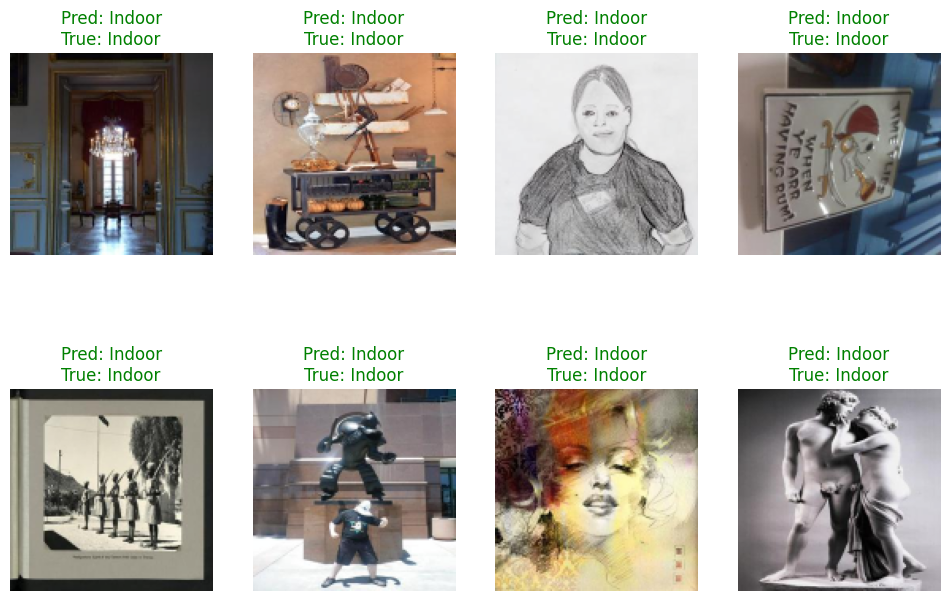

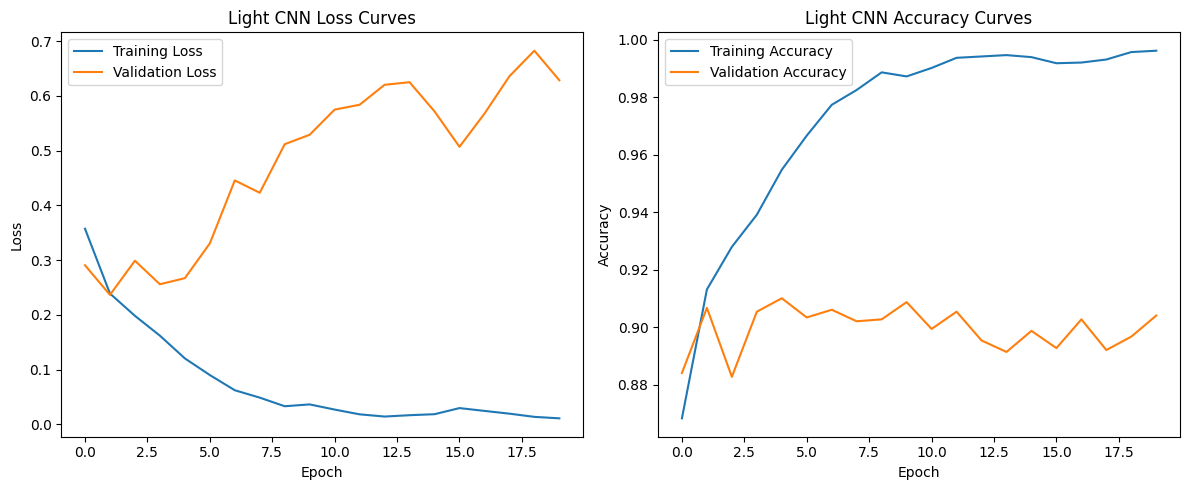

Evaluating: 100%|██████████| 7/7 [00:00<00:00, 18.26it/s]



Light CNN Performance:
Accuracy: 0.9150
Precision: 0.9368
Recall: 0.8900
F1-Score: 0.9128
ROC-AUC: 0.9644
Cohen's Kappa: 0.8300
Matthews CC: 0.8310
Confusion Matrix:
[[94  6]
 [11 89]]


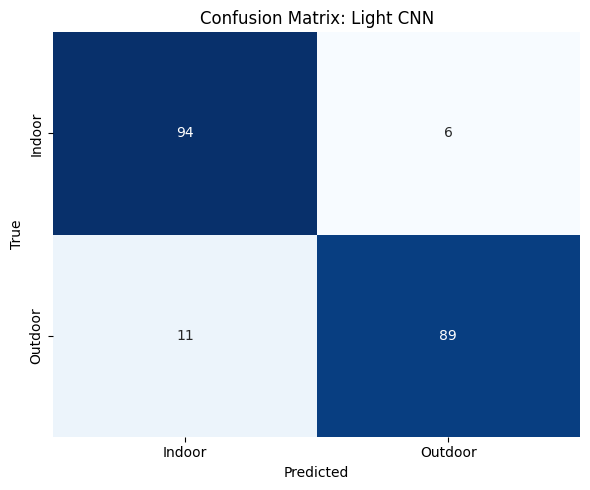

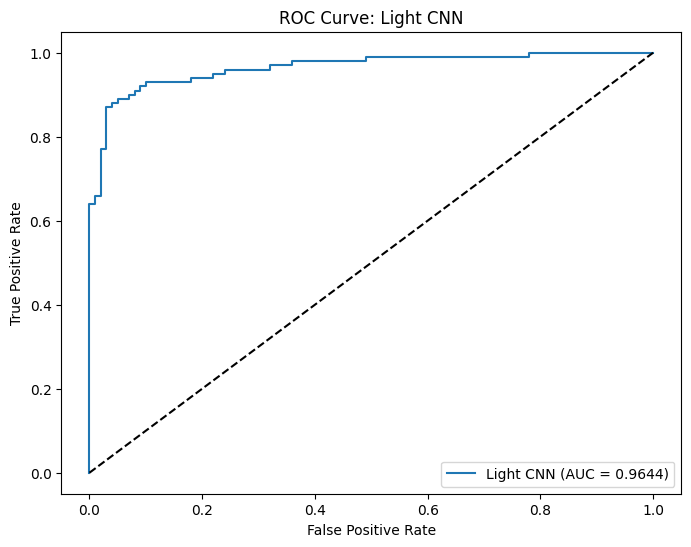


Model Comparison:
            Accuracy  Precision  Recall  F1-Score  ROC-AUC  Cohen's Kappa  \
Simple CNN     0.915   0.966292    0.86  0.910053   0.9708           0.83   
Deep CNN       0.930   0.967391    0.89  0.927083   0.9775           0.86   
Light CNN      0.915   0.936842    0.89  0.912821   0.9644           0.83   

            Matthews CC  
Simple CNN     0.835068  
Deep CNN       0.862765  
Light CNN      0.831039  


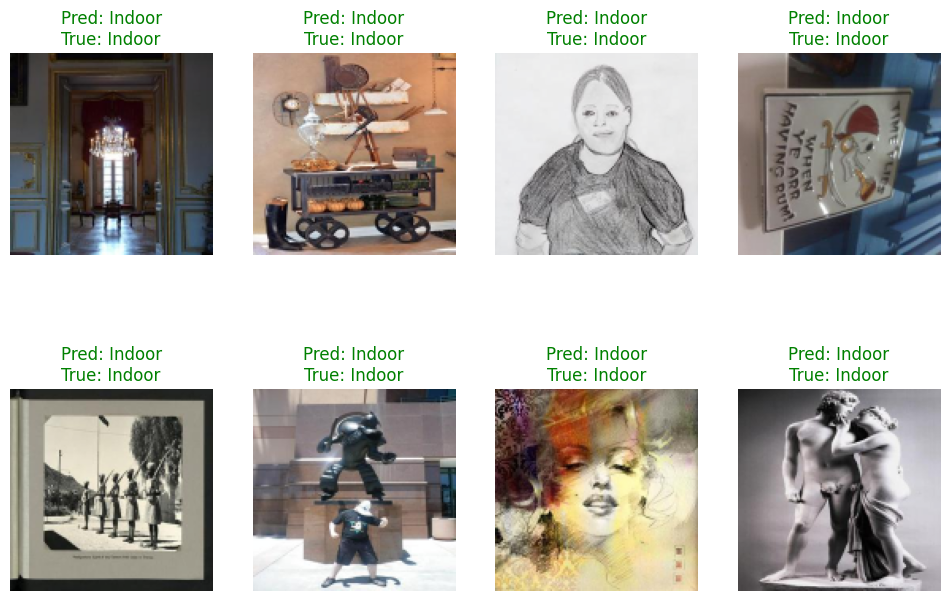

<Figure size 1200x800 with 0 Axes>

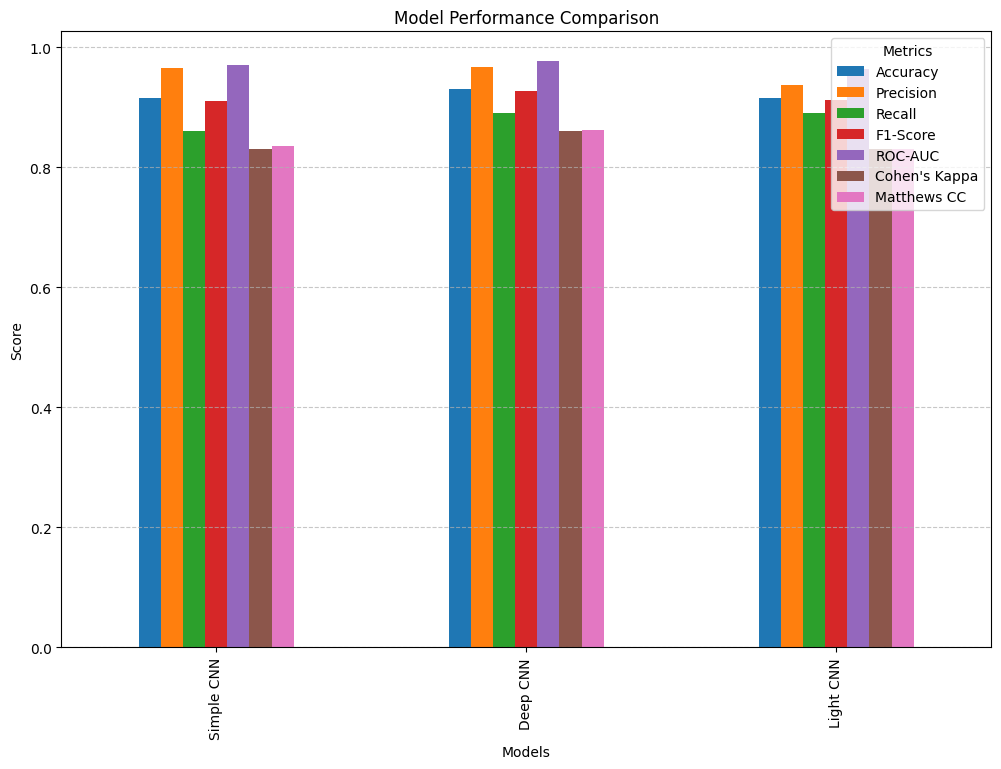


----------------------------------------
Hyperparameter Study: Learning Rate
----------------------------------------

Training with learning rate: 0.0001


Epoch 1/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 49.80it/s]


Epoch 1/10: Train Loss: 0.3736, Train Acc: 0.8388, Val Loss: 0.3195, Val Acc: 0.8727
Model saved with validation accuracy: 0.8727


Epoch 2/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 50.42it/s]


Epoch 2/10: Train Loss: 0.2748, Train Acc: 0.8949, Val Loss: 0.2787, Val Acc: 0.8920
Model saved with validation accuracy: 0.8920


Epoch 3/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 50.09it/s]


Epoch 3/10: Train Loss: 0.2486, Train Acc: 0.9061, Val Loss: 0.2604, Val Acc: 0.8960
Model saved with validation accuracy: 0.8960


Epoch 4/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 49.05it/s]


Epoch 4/10: Train Loss: 0.2273, Train Acc: 0.9148, Val Loss: 0.2530, Val Acc: 0.9020
Model saved with validation accuracy: 0.9020


Epoch 5/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 50.64it/s]


Epoch 5/10: Train Loss: 0.2099, Train Acc: 0.9226, Val Loss: 0.2362, Val Acc: 0.9087
Model saved with validation accuracy: 0.9087


Epoch 6/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 49.15it/s]


Epoch 6/10: Train Loss: 0.1936, Train Acc: 0.9300, Val Loss: 0.2376, Val Acc: 0.9093
Model saved with validation accuracy: 0.9093


Epoch 7/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 50.40it/s]


Epoch 7/10: Train Loss: 0.1795, Train Acc: 0.9341, Val Loss: 0.2664, Val Acc: 0.9053


Epoch 8/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 50.13it/s]


Epoch 8/10: Train Loss: 0.1695, Train Acc: 0.9382, Val Loss: 0.2314, Val Acc: 0.9100
Model saved with validation accuracy: 0.9100


Epoch 9/10 (Val): 100%|██████████| 47/47 [00:01<00:00, 42.96it/s]


Epoch 9/10: Train Loss: 0.1541, Train Acc: 0.9421, Val Loss: 0.2566, Val Acc: 0.9047


Epoch 10/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 50.33it/s]


Epoch 10/10: Train Loss: 0.1429, Train Acc: 0.9472, Val Loss: 0.2274, Val Acc: 0.9153
Model saved with validation accuracy: 0.9153


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 25.89it/s]



CNN (LR=0.0001) Performance:
Accuracy: 0.9450
Precision: 0.9785
Recall: 0.9100
F1-Score: 0.9430
ROC-AUC: 0.9741
Cohen's Kappa: 0.8900
Matthews CC: 0.8922
Confusion Matrix:
[[98  2]
 [ 9 91]]


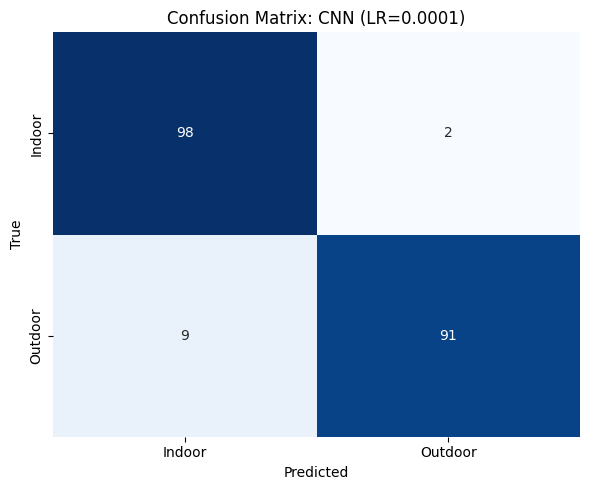

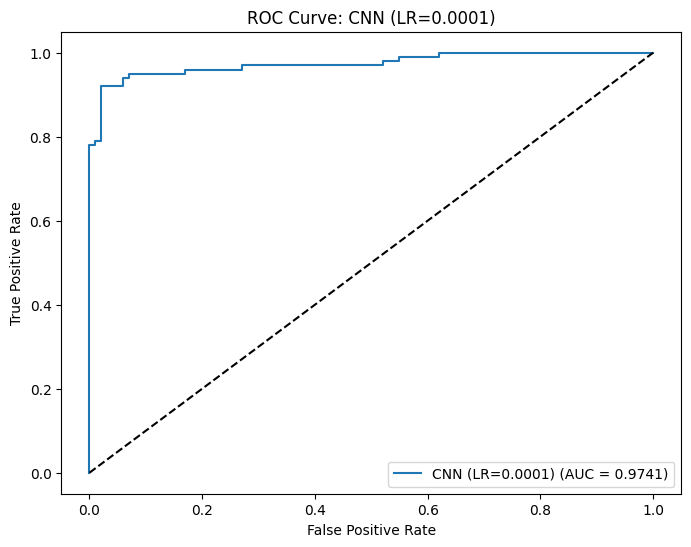


Training with learning rate: 0.001


Epoch 1/10 (Val): 100%|██████████| 47/47 [00:01<00:00, 34.93it/s]


Epoch 1/10: Train Loss: 0.3189, Train Acc: 0.8749, Val Loss: 0.2413, Val Acc: 0.8987
Model saved with validation accuracy: 0.8987


Epoch 2/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 50.81it/s]


Epoch 2/10: Train Loss: 0.2254, Train Acc: 0.9179, Val Loss: 0.2322, Val Acc: 0.9140
Model saved with validation accuracy: 0.9140


Epoch 3/10 (Val): 100%|██████████| 47/47 [00:01<00:00, 34.19it/s]


Epoch 3/10: Train Loss: 0.2078, Train Acc: 0.9236, Val Loss: 0.2368, Val Acc: 0.9073


Epoch 4/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 47.21it/s]


Epoch 4/10: Train Loss: 0.1762, Train Acc: 0.9351, Val Loss: 0.2161, Val Acc: 0.9207
Model saved with validation accuracy: 0.9207


Epoch 5/10 (Val): 100%|██████████| 47/47 [00:01<00:00, 32.56it/s]


Epoch 5/10: Train Loss: 0.1438, Train Acc: 0.9478, Val Loss: 0.2240, Val Acc: 0.9153


Epoch 6/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 50.24it/s]


Epoch 6/10: Train Loss: 0.1169, Train Acc: 0.9553, Val Loss: 0.2498, Val Acc: 0.9073


Epoch 7/10 (Val): 100%|██████████| 47/47 [00:01<00:00, 33.63it/s]


Epoch 7/10: Train Loss: 0.0794, Train Acc: 0.9722, Val Loss: 0.3040, Val Acc: 0.9127


Epoch 8/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 48.64it/s]


Epoch 8/10: Train Loss: 0.0610, Train Acc: 0.9773, Val Loss: 0.4120, Val Acc: 0.9153


Epoch 9/10 (Val): 100%|██████████| 47/47 [00:01<00:00, 34.94it/s]


Epoch 9/10: Train Loss: 0.0478, Train Acc: 0.9851, Val Loss: 0.4388, Val Acc: 0.8953


Epoch 10/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 49.53it/s]


Epoch 10/10: Train Loss: 0.0384, Train Acc: 0.9866, Val Loss: 0.3936, Val Acc: 0.9080


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 26.02it/s]



CNN (LR=0.001) Performance:
Accuracy: 0.9450
Precision: 0.9890
Recall: 0.9000
F1-Score: 0.9424
ROC-AUC: 0.9799
Cohen's Kappa: 0.8900
Matthews CC: 0.8936
Confusion Matrix:
[[99  1]
 [10 90]]


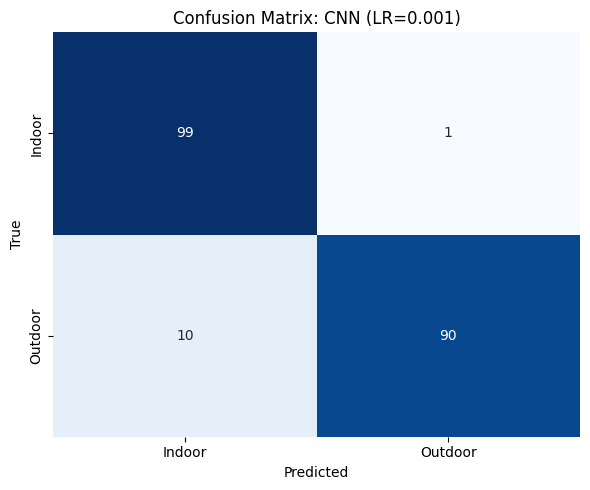

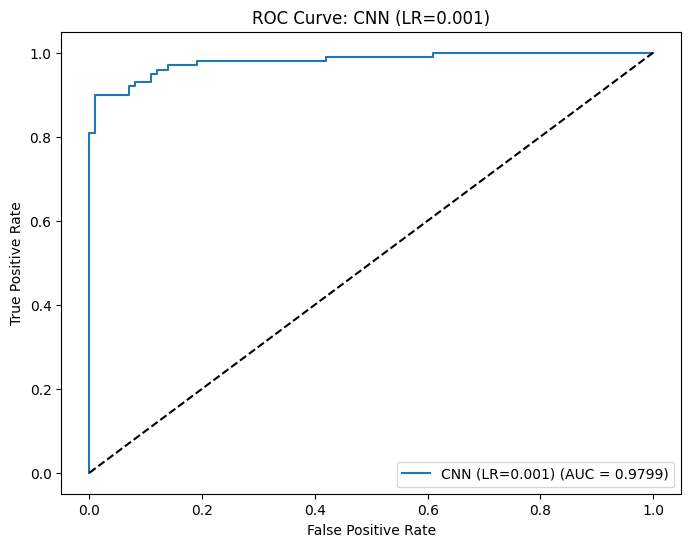


Training with learning rate: 0.01


Epoch 1/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 48.06it/s]


Epoch 1/10: Train Loss: 0.8401, Train Acc: 0.4974, Val Loss: 0.6932, Val Acc: 0.5000
Model saved with validation accuracy: 0.5000


Epoch 2/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 49.66it/s]


Epoch 2/10: Train Loss: 0.6937, Train Acc: 0.4998, Val Loss: 0.6934, Val Acc: 0.5000


Epoch 3/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 50.05it/s]


Epoch 3/10: Train Loss: 0.6931, Train Acc: 0.5111, Val Loss: 0.6931, Val Acc: 0.5000


Epoch 4/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 49.70it/s]


Epoch 4/10: Train Loss: 0.6940, Train Acc: 0.4944, Val Loss: 0.6934, Val Acc: 0.5000


Epoch 5/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 49.38it/s]


Epoch 5/10: Train Loss: 0.6936, Train Acc: 0.4922, Val Loss: 0.6932, Val Acc: 0.5000


Epoch 6/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 48.15it/s]


Epoch 6/10: Train Loss: 0.6935, Train Acc: 0.5014, Val Loss: 0.6932, Val Acc: 0.5000


Epoch 7/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 50.29it/s]


Epoch 7/10: Train Loss: 0.6936, Train Acc: 0.4982, Val Loss: 0.6932, Val Acc: 0.5000


Epoch 8/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 50.60it/s]


Epoch 8/10: Train Loss: 0.6936, Train Acc: 0.4960, Val Loss: 0.6935, Val Acc: 0.5000


Epoch 9/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 50.28it/s]


Epoch 9/10: Train Loss: 0.6937, Train Acc: 0.4988, Val Loss: 0.6932, Val Acc: 0.5000


Epoch 10/10 (Val): 100%|██████████| 47/47 [00:00<00:00, 50.51it/s]


Epoch 10/10: Train Loss: 0.6937, Train Acc: 0.5012, Val Loss: 0.6933, Val Acc: 0.5000


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 25.81it/s]



CNN (LR=0.01) Performance:
Accuracy: 0.5000
Precision: 0.5000
Recall: 1.0000
F1-Score: 0.6667
ROC-AUC: 0.4950
Cohen's Kappa: 0.0000
Matthews CC: 0.0000
Confusion Matrix:
[[  0 100]
 [  0 100]]


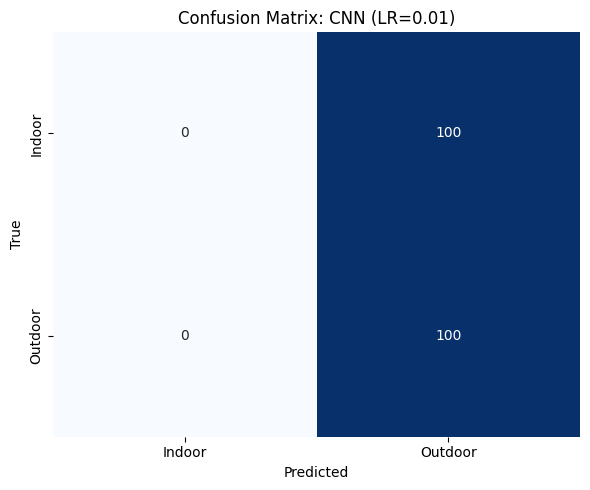

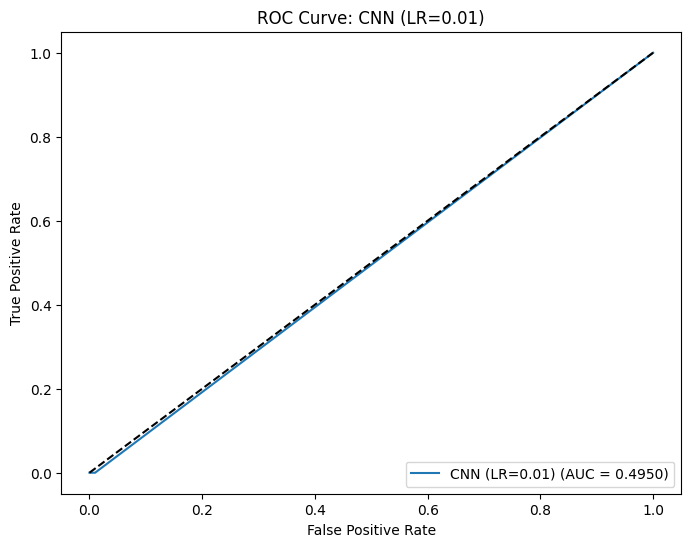

<Figure size 800x600 with 0 Axes>

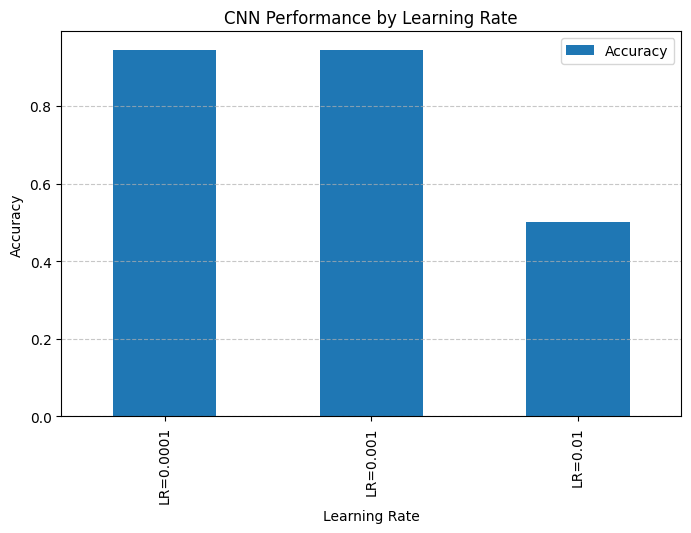


----------------------------------------
Hyperparameter Study: Network Architecture
----------------------------------------
Error loading phase 1 models: [Errno 2] No such file or directory: 'dt_model.pkl'
Skipping comparison with phase 1 models.

Saving final models...

CNN training and evaluation complete!


In [11]:
if __name__ == "__main__":
    main()